<a href="https://colab.research.google.com/github/mattiasthalen/Bayesian-Velocity-Profiling/blob/main/Bayesian_Velocity_Profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Velocity Profiling

## Setup Environment


### Install Libraries

In [1]:
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade pymc
!pip install --upgrade numpyro
!pip install --upgrade blackjax
!pip install --upgrade pint_xarray
!pip install --upgrade bottleneck
!pip install --upgrade numbagg
!pip install --upgrade ipython-autotime
!pip install --upgrade netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 8.6 MB/s 
     |████████████████████████████████| 128 kB 36.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 12.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 355 kB 7.5 MB/s 
Looking in indexes: 

### Setup Platform

In [2]:
import numpyro
import jax
import jax.tools.colab_tpu

try:
    
    jax.tools.colab_tpu.setup_tpu()
    numpyro.util.set_platform('tpu')

    print('TPU assigned.')
    display(jax.local_devices())

except:
    print('No TPU available, trying GPU.')
    
    try:
        numpyro.set_platform('gpu')
        print('GPU assigned.')
        display(jax.local_devices())

    except:
        numpyro.set_platform('cpu')
        print('No GPU available, using CPU.')
        display(jax.local_devices())

No TPU available, trying GPU.
GPU assigned.
No GPU available, using CPU.


[CpuDevice(id=0)]

### Load Libraries

In [3]:
%load_ext autotime

time: 803 µs (started: 2022-10-03 05:38:21 +00:00)


In [4]:
import pymc as pm
import pymc.sampling_jax

time: 5.15 s (started: 2022-10-03 05:38:21 +00:00)


/usr/local/lib/python3.7/dist-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [5]:
import time
import pint_xarray
import warnings

import requests
import numpyro
import sklearn.preprocessing
import sklearn.metrics

import pandas as pd
import numpy as np
import arviz as az
import xarray as xr

from jax import numpy as jnp
from numpyro import distributions as dist

from collections import OrderedDict
from google.colab import drive
from requests import get
from urllib.parse import unquote

from requests import get
from urllib.parse import unquote
from matplotlib import pyplot as plt

from typing import Callable, Optional, Dict, List, Union, NoReturn

time: 413 ms (started: 2022-10-03 05:38:26 +00:00)


### Set Global Vars

In [6]:
#rng_key = jax.random.PRNGKey(33)
n_devices = np.max([2, len(jax.local_devices())])
numpyro.set_host_device_count(n_devices)

time: 3.37 ms (started: 2022-10-03 05:38:26 +00:00)


In [7]:
plt.style.use('bmh')

time: 1.96 ms (started: 2022-10-03 05:38:27 +00:00)


In [8]:
csv_path = 'https://raw.githubusercontent.com/mattiasthalen/Bayesian-Velocity-Profiling/main/RepOne_Data_Export.csv'

time: 906 µs (started: 2022-10-03 05:38:27 +00:00)


## Functions

### Miscellaneous Functions

In [19]:
def assign_set_type(da):
    set_category = xr.where(da['set'] < da.idxmax('set'), 'Work Up', np.nan)
    set_category = xr.where(da['set'] == da.idxmax('set'), 'Top Set', set_category)
    set_category = xr.where(da['set'] > da.idxmax('set'), 'Back Off', set_category)
    set_category = xr.where(np.isnan(da), np.nan, set_category)
    
    return set_category

time: 3.12 ms (started: 2022-10-03 05:38:27 +00:00)


In [20]:
def agg_summarize(x):
    x = x[np.isfinite(x)]

    if len(x) > 0:
        min = np.min(x)
        max = np.max(x)
        first = x[0]
        last = x[-1]
        peak_end = np.mean([min, last])
        mean = np.mean(x)
        median = np.median(x)
        hdi = az.hdi(x)
        result = np.array([min, max, first, last, peak_end, mean, median, *hdi])
    else:
        result = np.array([np.nan]*9)
    
    return result

def summarize(x, reduce_dim = 'rep'):
    summaries = xr.apply_ufunc(agg_summarize,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['aggregation']])
    
    summaries['aggregation'] = ['min', 'max', 'first', 'last', 'peak_end', 'mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

time: 2.5 ms (started: 2022-10-03 05:38:27 +00:00)


In [21]:
def agg_hdi_summary(x):
    mean = x.mean()
    median = np.median(x)
    hdi = az.hdi(x)

    return np.array([mean, median, *hdi])

def hdi_summary(x, reduce_dim = 'sample'):
    try:
        x = x.pint.dequantify()
    except:
        pass

    summaries = xr.apply_ufunc(agg_hdi_summary,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['hdi_aggregation']])
    
    summaries['hdi_aggregation'] = ['mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

time: 4.12 ms (started: 2022-10-03 05:38:27 +00:00)


In [22]:
def all_nan_summary(x, mode = 'mean', **kwargs):
    if np.all(np.isnan(x)):
        return np.nan
    elif mode == 'max':
        return np.nanmax(x)
    elif mode == 'min':
        return np.nanmin(x)
    elif mode == 'mean':
        return np.nanmean(x)
    elif mode == 'sum':
        return np.nansum(x)
        
def all_nan_max(x, **kwargs):
    return all_nan_summary(x, 'max', **kwargs)
        
def all_nan_min(x, **kwargs):
    return all_nan_summary(x, 'min', **kwargs)
        
def all_nan_mean(x, **kwargs):
    return all_nan_summary(x, 'mean', **kwargs)
        
def all_nan_sum(x, **kwargs):
    return all_nan_summary(x, 'sum', **kwargs)

time: 8.32 ms (started: 2022-10-03 05:38:27 +00:00)


### Plotting Functions

In [11]:
def plot_pbc(ds, exercise, data_var, window = 20, signal_window = 8, ax = None):
    df = ds[data_var].sel({'exercise': exercise}, drop = True)\
                     .drop_vars(['training_cycle', 'cycle_type', 'max_weight_pr_flag'])\
                     .to_dataframe()\
                     .dropna()
    
    df['moving_average'] = df[data_var].sort_index(ascending = False)\
                                       .rolling(window, min_periods = 1)\
                                       .mean()
    
    df['moving_range'] = df[data_var].diff(-1)\
                                     .abs()\
                                     .sort_index(ascending = False)\
                                     .rolling(window, min_periods = 1)\
                                     .mean()

    df['process_average'] = df['moving_average']
    df['process_range'] = df['moving_range']
    df['signal'] = None
    df['signal_min'] = None
    df['signal_max'] = None
    df['signal_above_average'] = None
    df['signal_below_average'] = None

    n_rows = len(df)
    previous_signal_id = 0

    for row in np.arange(n_rows):
        first_row = row == 0
        sufficient_rows_left = n_rows - row >= window

        signal_start_id = np.max([8, row - signal_window])

        df['signal_min'][row] = df[data_var][signal_start_id:row].min()
        df['signal_max'][row] = df[data_var][signal_start_id:row].max()

        df['signal_above_average'][row] = (df['signal_min'][row] > df['process_average'][row - 1])
        df['signal_below_average'][row] = (df['signal_max'][row] < df['process_average'][row - 1])

        signal_open = (first_row) | (row >= previous_signal_id + window)
        signal = (signal_open) & (sufficient_rows_left) & (first_row | df['signal_above_average'][row] | df['signal_below_average'][row])
        df['signal'][row] = signal
        
        df['process_average'][row] =  df['process_average'][row - 1]
        df['process_range'][row] =  df['process_range'][row - 1]

        if signal:
            previous_signal_id = row
            df['process_average'][row] =  df['moving_average'][row]
            df['process_range'][row] =  df['moving_range'][row]
        else:
            df['process_average'][row] =  df['process_average'][row - 1]
            df['process_range'][row] =  df['process_range'][row - 1]

    df['lower_limit_1'] = df['process_average'] - df['process_range']/1.128
    df['upper_limit_1'] = df['process_average'] + df['process_range']/1.128
    df['lower_limit_2'] = df['process_average'] - df['process_range']*2/1.128
    df['upper_limit_2'] = df['process_average'] + df['process_range']*2/1.128
    df['lower_limit_3'] = df['process_average'] - df['process_range']*3/1.128
    df['upper_limit_3'] = df['process_average'] + df['process_range']*3/1.128

    if ax is None:
        ax = plt.gca()

    ax.scatter(df.index, df[data_var], marker = '.', alpha = 0.6)
    ax.plot(df.index, df['process_average'])
    ax.plot(df.index, df['lower_limit_3'])
    ax.plot(df.index, df['upper_limit_3'])

    ax.fill_between(df.index,df['lower_limit_1'], df['upper_limit_1'], alpha = 0.3)

    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_ylim([0, None])
    ax.tick_params(labelrotation = 90)
    ax.grid()

    return ax

time: 9.47 ms (started: 2022-10-03 05:38:27 +00:00)


In [12]:
def plot_kpis(ds, exercise, vars):
    var_titles = [var.title().replace('_', ' ').replace('1Rm', '1RM') for var in vars]

    n_vars = len(vars)

    n_cols = 1

    if n_vars > 1:
        n_cols = 2
    
    n_rows = 1

    if n_vars > 2:
        n_rows = np.ceil(n_vars/n_cols).astype(int)
    
    figsize = np.array([6, 3]) * [n_cols, n_rows]

    fig, axes = plt.subplots(ncols = n_cols,
                            nrows = n_rows,
                            constrained_layout = True,
                            figsize = figsize,
                            sharex = True)
    
    axes = [ax for row in axes for ax in row]

    for key, val in enumerate(vars):
        plot_pbc(ds, exercise, vars[key], ax = axes[key])
        title = var_titles[key]
        axes[key].set_title(title)

    fig.suptitle(f'{exercise.title()} KPIs', fontsize = 16)
    fig.supxlabel('Workout Start Time')

    plt.draw()

time: 4.49 ms (started: 2022-10-03 05:38:27 +00:00)


## Extract, Transform, Load

### Extract

In [49]:
df = pd.read_csv(csv_path)

df.columns = (df.columns
                .str.lower()
                .str.replace(' \(m/s\)', '')
                .str.replace(' \(mm\)', '')
                .str.replace(' \(sec\)', '')
                .str.replace(' \(%\)', '')
                .str.replace(' ', '_'))
    
df.rename(columns = {'weight': 'load'}, inplace = True)

df['workout_start_time'] = pd.to_datetime(df['workout_start_time'], format = '%d/%m/%Y, %H:%M:%S')

df.dropna(subset = ['exercise'], inplace = True)
df['rest_time'] = pd.to_timedelta(df['rest_time'])

# Correct split session
df['set'].mask((df['exercise'] == 'deadlift') & (df['workout_start_time'] == pd.to_datetime('2020-12-30 13:06:04')), df['set'] + 7, inplace = True)
df.replace({'workout_start_time': pd.to_datetime('2020-12-30 13:06:04')}, pd.to_datetime('2020-12-30 12:53:09'), inplace = True)
df.replace({'workout_start_time': pd.to_datetime('2021-01-07 11:50:22')}, pd.to_datetime('2021-01-07 11:20:07'), inplace = True)
df.replace({'workout_start_time': pd.to_datetime('2021-06-10 12:02:22')}, pd.to_datetime('2021-06-10 11:56:31'), inplace = True)
df.replace({'workout_start_time': pd.to_datetime('2021-06-14 12:06:00')}, pd.to_datetime('2021-06-14 11:57:50'), inplace = True)

# Reindex sets & reps to counter bugs in the extract
df['set'] = df.groupby(['exercise', 'workout_start_time'])['set'].apply(lambda x: (x != x.shift()).cumsum() - 1)
df['rep'] = df.groupby(['exercise', 'workout_start_time', 'set']).cumcount()

# Convert from , to . as decimal sign
df['load'] = df['load'].str.replace(',', '.').astype('float')

# Drop rows with tag fail
fail_filter = df['tags'].str.contains('fail', na = False)
df = df[~fail_filter]

# Handle the case when a rep is split into two reps
rep_split_filter = df['tags'].str.contains('rep split', na = False)

rep_split_df = df[rep_split_filter].groupby(['exercise', 'workout_start_time', 'set', 'load', 'metric'])[['range_of_motion', 'duration_of_rep']].sum()
rep_split_df['avg_velocity'] = rep_split_df['range_of_motion']/1000/rep_split_df['duration_of_rep']
rep_split_df['rep'] = 0
rep_split_df.reset_index(inplace = True)

rep_split_df = rep_split_df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

df = pd.concat([df[~rep_split_filter], rep_split_df])

# Group to get multi index
df = df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


load metric set_rpe       tags  \
exercise    workout_start_time  set rep                                    
bench press 2021-01-05 10:56:06 0.0 0.0   20.0    kgs     NaN  wide grip   
                                    1.0   20.0    kgs     NaN  wide grip   
                                    2.0   20.0    kgs     NaN  wide grip   
                                1.0 0.0   30.0    kgs     NaN  wide grip   
                                    1.0   30.0    kgs     NaN  wide grip   
...                                        ...    ...     ...        ...   
squat       2022-10-02 20:18:38 4.0 0.0  100.0    kgs     NaN   high bar   
                                5.0 0.0  120.0    kgs     NaN   high bar   
                                6.0 0.0  130.0    kgs     NaN   high bar   
                                7.0 0.0  135.0    kgs     NaN   high bar   
                                8.0 0.0  140.0    kgs     NaN   high bar   

                                                     rest_time  avg_velocity  \
exercise    workout_start_time  set rep                                        
bench press 2021-01-05 10:56:06 0.0 0.0 0 days 00:02:07.600000          0.77   
                                    1.0 0 days 00:02:07.600000          0.73   
                                    2.0 0 days 00:02:07.600000          0.70   
                                1.0 0.0 0 days 00:01:13.300000          0.65   
                                    1.0 0 days 00:01:13.300000          0.77   
...                                                        ...           ...   
squat       2022-10-02 20:18:38 4.0 0.0 0 days 00:01:15.700000          0.55   
                                5.0 0.0        0 days 00:01:26          0.44   
                                6.0 0.0 0 days 00:01:26.500000          0.34   
                                7.0 0.0 0 days 00:02:50.600000          0.29   
                                8.0 0.0 0 days 00:02:58.100000          0.21   

                                         range_of_motion  peak_velocity  \
exercise    workout_start_time  set rep                                   
bench press 2021-01-05 10:56:06 0.0 0.0              286           1.31   
                                    1.0              294           1.38   
                                    2.0              300           1.26   
                                1.0 0.0              270           1.09   
                                    1.0              308           1.33   
...                                                  ...            ...   
squat       2022-10-02 20:18:38 4.0 0.0              722           0.94   
                                5.0 0.0              727           0.96   
                                6.0 0.0              734           0.95   
                                7.0 0.0              713           0.71   
                                8.0 0.0              712           0.77   

                                         peak_velocity_location  \
exercise    workout_start_time  set rep                           
bench press 2021-01-05 10:56:06 0.0 0.0                   204.0   
                                    1.0                   179.0   
                                    2.0                   209.0   
                                1.0 0.0                   157.0   
                                    1.0                   210.0   
...                                                         ...   
squat       2022-10-02 20:18:38 4.0 0.0                   645.0   
                                5.0 0.0                   647.0   
                                6.0 0.0                   658.0   
                                7.0 0.0                   650.0   
                                8.0 0.0                   648.0   

                                         duration_of_rep  
exercise    workout_start_time  set rep                   
bench press 2021-01-05 10:56:06 0.0 0.0       

time: 2.84 s (started: 2022-10-03 06:29:59 +00:00)


### Transform

In [62]:
# Convert to xarray
ds = df.to_xarray()

# Change Set and Rep to integers
ds['set'] = ds['set'].astype(int)
ds['rep'] = ds['rep'].astype(int)

# Move variables to coords
ds = ds.set_coords(['metric', 'tags'])

# Define UOMs
ds = ds.pint.quantify({'load': 'kg',
                        'avg_velocity': 'meter / second',
                        'peak_velocity': 'meter / seconds',
                        'range_of_motion': 'mm',
                        'duration_of_rep': 's'})

# Session meta data
session_stack = ['exercise', 'workout_start_time']
ds['session_max_load'] = ds['load'].stack(stack = session_stack)\
                                    .groupby('stack')\
                                    .reduce(all_nan_max, ...)\
                                    .unstack()

# Set meta data
set_stack = [*session_stack, 'set']
ds['load'] = (ds['load'].stack(stack = set_stack)
                        .groupby('stack')
                        .reduce(all_nan_max, ...)
                        .unstack())

ds['reps'] = (ds['avg_velocity'].stack(stack = set_stack)
                                .groupby('stack')
                                .count(...)
                                .unstack()
                                .where(ds['load'] > 0, drop = True))

ds['set_velocities'] = summarize(ds['avg_velocity'].pint.dequantify())
ds['set_velocities'] = ds['set_velocities'].pint.quantify({ds['set_velocities'].name: 'mps'})

ds.coords['set_type'] = assign_set_type(ds['load'])

# Add the running min top set velocity per exercise
ds['minimum_velocity_threshold'] = (ds['set_velocities'].sel({'aggregation': 'first'})
                                                        .where(ds.coords['set_type'] == 'Top Set')
                                                        .pint.dequantify()
                                                        .stack(stack = session_stack)
                                                        .groupby('stack')
                                                        .reduce(all_nan_min, ...)
                                                        .unstack()
                                                        .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                                min_periods = 1)
                                                        .min())
ds['minimum_velocity_threshold'] = ds['minimum_velocity_threshold'].pint.quantify({ds['minimum_velocity_threshold'].name: 'meter / second'})

# Add running max load per exercise
ds['rolling_max_load'] = (ds['load'].pint.dequantify()
                                            .stack(stack = session_stack)
                                            .groupby('stack')
                                            .reduce(all_nan_max, ...)
                                            .unstack()
                                            .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                    min_periods = 1)
                                            .max())
ds['rolling_max_load'] = ds['rolling_max_load'].pint.quantify({ds['rolling_max_load'].name: 'kg'})

# Additional session meta data
ds['workup_sets'] = ds['load'].where(ds.coords['set_type'] == 'Work Up', drop = True)\
                                .stack(stack = session_stack)\
                                .groupby('stack')\
                                .count(...)\
                                .unstack()

#ds['session_regression_coefficients'] = linear_fit(ds, 'load', 'set_velocities', 'set')

#ds['estimated_1rm'] = linear_predict(ds['minimum_velocity_threshold'].pint.dequantify(), ds['session_regression_coefficients'])
#ds['estimated_1rm'] = ds['estimated_1rm'].pint.quantify({ds['estimated_1rm'].name: 'kg'})

#ds['zero_velocity_load'] = linear_predict(0, ds['session_regression_coefficients'])
#ds['zero_velocity_load'] = ds['zero_velocity_load'].pint.quantify({ds['zero_velocity_load'].name: 'kg'})

#ds['zero_load_velocity'] = linear_predict(0, ds['session_regression_coefficients'], reverse = True)
#ds['zero_load_velocity'] = ds['zero_load_velocity'].pint.quantify({ds['zero_load_velocity'].name: 'mps'})

#ds['curve_score'] = ds['zero_velocity_load'].pint.dequantify()*ds['zero_load_velocity'].pint.dequantify()/2

ds['session_volume'] = (ds['load'] * ds['reps']).stack(stack = session_stack).groupby('stack').sum(...).unstack()
#ds['session_relative_volume'] = ds['session_volume']/ds['estimated_1rm']

# Rep meta data
#ds['rep_exertion'] = linear_predict(ds['avg_velocity'].pint.dequantify(), ds['session_regression_coefficients'])/ds['estimated_1rm'].pint.dequantify()
#ds['rep_force'] = (ds['load']*ds['range_of_motion'].pint.to('meter')/ds['duration_of_rep']**2).pint.to('N')
#ds['rep_energy'] = (ds['rep_force']*ds['range_of_motion'].pint.to('meter')).pint.to('J')

# Session meta data
#ds['session_exertion_load'] = ds['rep_exertion'].stack(stack = ['exercise', 'workout_start_time']).groupby('stack').reduce(all_nan_sum, ...).unstack().pint.dequantify()

# Add PR coordinates
ds.coords['max_load_pr_flag'] = ds['rolling_max_load'].diff('workout_start_time') > 0

# Add indexing for inference
session = ds.stack({'session': ['workout_start_time', 'exercise']})
session['session_id'] = ('session', np.arange(session.dims['session']))
ds.coords['session'] = session['session_id'].unstack('session')

ds.coords['exercise_id'] = ('exercise', np.arange(ds.dims['exercise']))

observation = ds.stack({'observation': ['exercise', 'workout_start_time', 'set']})
observation['observation_id'] = ('observation', np.arange(observation.dims['observation']))

ds.coords['observation'] = observation['observation_id'].unstack('observation')

ds

<xarray.Dataset>
Dimensions:                     (exercise: 5, workout_start_time: 186, set: 22, rep: 10, aggregation: 9)
Coordinates:
  * exercise                    (exercise) object 'bench press' ... 'squat'
  * workout_start_time          (workout_start_time) datetime64[ns] 2020-12-3...
  * set                         (set) int64 0 1 2 3 4 5 6 ... 16 17 18 19 20 21
  * rep                         (rep) int64 0 1 2 3 4 5 6 7 8 9
    metric                      (exercise, workout_start_time, set, rep) object ...
    tags                        (exercise, workout_start_time, set, rep) object ...
  * aggregation                 (aggregation) <U9 'min' 'max' ... 'hdi_upper'
    set_type                    (exercise, workout_start_time, set) object na...
    max_load_pr_flag            (exercise, workout_start_time, set) float64 n...
    session                     (exercise, workout_start_time, set) int64 0 ....
    exercise_id                 (exercise, workout_start_time, set) int64 0 ....
    observation                 (exercise, workout_start_time, set) int64 0 ....
Data variables: (12/15)
    load                        (exercise, workout_start_time, set) float64 [kg] ...
    set_rpe                     (exercise, workout_start_time, set, rep) object ...
    rest_time                   (exercise, workout_start_time, set, rep) timedelta64[ns] ...
    avg_velocity                (exercise, workout_start_time, set, rep) float64 [m/s] ...
    range_of_motion             (exercise, workout_start_time, set, rep) float64 [mm] ...
    peak_velocity               (exercise, workout_start_time, set, rep) float64 [m/s] ...
    ...                          ...
    reps                        (exercise, workout_start_time, set) float64 n...
    set_velocities              (exercise, workout_start_time, set, aggregation) float64 [mps] ...
    minimum_velocity_threshold  (exercise, workout_start_time) float64 [m/s] ...
    rolling_max_load            (exercise, workout_start_time) float64 [kg] n...
    workup_sets                 (exercise, workout_start_time) int64 0 0 ... 7 8
    session_volume              (exercise, workout_start_time) float64 [kg] 0...

time: 7.27 s (started: 2022-10-03 06:43:56 +00:00)


### Prepare Data For Inference

In [63]:
regr_data = (ds[['load', 'set_velocities', 'exercise_id', 'observation', 'session']]
             .pint.dequantify()
             .sel({'aggregation': 'max'}, drop = True)
             .where(data.coords['set_type'] != 'Back Off')
             .where(data.coords['exercise'] != 'front squat')
             .drop_vars(['set_type', 'max_load_pr_flag'])
             .to_dataframe()
             .dropna()
             .reset_index()
             .sort_values(by = ['workout_start_time', 'exercise', 'set'])
             .rename(columns = {'set_velocities': 'velocity'}))

# Standardize data to simplify inference
load_scaler = sklearn.preprocessing.StandardScaler()
regr_data['load_scaled'] = load_scaler.fit_transform(regr_data['load'].values.reshape(-1, 1))

velocity_scaler = sklearn.preprocessing.StandardScaler()
regr_data['velocity_scaled'] = velocity_scaler.fit_transform(regr_data['velocity'].values.reshape(-1, 1))

regr_data

,exercise,workout_start_time,set,load,velocity,exercise_id,observation,session,load_scaled,velocity_scaled
309,deadlift,2020-12-30 12:53:09,0,70.0,0.63,1,4092,1,-0.060235,0.047590
310,deadlift,2020-12-30 12:53:09,1,80.0,0.50,1,4093,1,0.186195,-0.362148
311,deadlift,2020-12-30 12:53:09,2,90.0,0.49,1,4094,1,0.432625,-0.393667
312,deadlift,2020-12-30 12:53:09,3,100.0,0.64,1,4095,1,0.679055,0.079109
313,deadlift,2020-12-30 12:53:09,4,110.0,0.48,1,4096,1,0.925485,-0.425185
...,...,...,...,...,...,...,...,...,...,...
2868,squat,2022-10-02 20:18:38,4,100.0,0.55,4,20442,929,0.679055,-0.204557
2869,squat,2022-10-02 20:18:38,5,120.0,0.44,4,20443,929,1.171915,-0.551259
2870,squat,2022-10-02 20:18:38,6,130.0,0.34,4,20444,929,1.418345,-0.866442
2871,squat,2022-10-02 20:18:38,7,135.0,0.29,4,20445,929,1.541560,-1.024034


time: 71.3 ms (started: 2022-10-03 06:44:26 +00:00)


In [ ]:
map_session_to_exercise_id = (regr_data[['session_id', 'exercise_id']]
                              .drop_duplicates()
                              .set_index('session_id', verify_integrity = True)
                              .sort_index()['exercise_id']
                              .values)

map_session_to_exercise_id

array([1, 3, 1, 3, 0, 4, 1, 3, 0, 4, 1, 3, 0, 4, 1, 3, 0, 4, 1, 3, 0, 4,
       1, 3, 3, 4, 3, 4, 3, 4, 3, 4, 1, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1, 3, 0, 4, 1, 3, 0, 4, 1, 3, 1,
       3, 1, 3, 1, 0, 4, 1, 3, 0, 4, 0, 3, 4, 1, 3, 4, 0, 3, 4, 1, 3, 4,
       0, 3, 4, 1, 3, 4, 0, 3, 4, 1, 3, 4, 0, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1, 3, 4, 3, 4, 1, 3, 1, 1, 3, 1,
       3, 4, 3, 4, 3, 4, 3, 4, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 1, 3, 1, 3, 3, 4, 3, 4, 3, 4, 1, 3, 4, 3, 4, 3, 4,
       3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 0, 4, 0, 4, 1, 3, 0, 4,
       1, 3, 0, 4, 1, 3, 0, 4, 3, 4, 0, 1, 3, 4, 0, 1, 3, 4, 3, 4, 0, 1,
       3, 4, 0, 1, 3, 4, 0, 1, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 4, 0, 0, 3, 0, 4, 0, 1, 4, 0, 1,
       3, 4, 0, 4, 1, 3, 0, 4, 0, 1, 4, 0, 4, 1, 3,

time: 15.4 ms (started: 2022-10-02 21:15:17 +00:00)


## Inference

### Define Model

In [ ]:
def build_model(velocity,
                load,
                session_exercise_idx,
                session_idx,
                coords,
                render_model = True):
    
    with pm.Model() as model:

        # Add coordinates
        model.add_coord('observation_id', coords['observation_id'], mutable = True)
        model.add_coord('exercise', coords['exercise'], mutable = False)
        model.add_coord('session_id', coords['session_id'], mutable = False)

        # Add inputs
        velocity = pm.Normal(name = 'velocity',
                             mu = 0.0,
                             sigma = 1.0,
                             observed = velocity,
                             dims = 'observation')

        # Global Parameters
        intercept_global = pm.Normal(name = 'intercept_global',
                                     mu = 0.0,
                                     sigma = 1.0)
        
        intercept_sigma_global = pm.HalfNormal(name = 'intercept_sigma_global',
                                               sigma = 1.0)
        
        slope_global = pm.HalfNormal(name = 'slope_global',
                                     sigma = 1.0)
        
        curve_global = pm.HalfNormal(name = 'curve_global',
                                     sigma = 1.0)
        
        error_global = pm.HalfNormal(name = 'error_global',
                                     sigma = 1.0)
        
        # Exercise Parameters
        intercept_offset_exercise = pm.Normal(name = 'intercept_offset_exercise',
                                              mu = 0.0,
                                              sigma = 1.0,
                                              dims = 'exercise')
        
        intercept_exercise = pm.Deterministic(name = 'intercept_exercise',
                                              var = intercept_global + intercept_sigma_global*intercept_offset_exercise,
                                              dims = 'exercise')
        
        intercept_sigma_exercise = pm.HalfNormal(name = 'intercept_sigma_exercise',
                                                 sigma = 1.0,
                                                 dims = 'exercise')
        
        slope_exercise = pm.HalfNormal(name = 'slope_exercise',
                                       sigma = slope_global,
                                       dims = 'exercise')
        
        curve_exercise = pm.HalfNormal(name = 'curve_exercise',
                                       sigma = curve_global,
                                       dims = 'exercise')

        # Session Parameters
        intercept_offset_session = pm.Normal(name = 'intercept_offset_session',
                                             mu = 0.0,
                                             sigma = 1.0,
                                             dims = 'session')

        intercept_session = pm.Deterministic(name = 'intercept_session',
                                                var = (intercept_exercise[session_exercise_idx]
                                                       + intercept_sigma_exercise[session_exercise_idx]
                                                       * intercept_offset_session),
                                                dims = 'session')
        
        slope_session = pm.HalfNormal(name = 'slope_session',
                                      sigma = slope_exercise[session_exercise_idx],
                                      dims = 'session')

        curve_session = pm.HalfNormal(name = 'curve_session',
                                      sigma = curve_exercise[session_exercise_idx],
                                      dims = 'session')
        
        # Final Parameters
        intercept = intercept_session[session_idx]
        slope = slope_session[session_idx]
        curve = curve_session[session_idx]
        error = error_global

        # Estimated Value
        load_mu = pm.Deterministic(name = 'mu',
                                   var = intercept - slope*velocity - curve*velocity**2,
                                   dims = 'observation')

        # Likelihood
        load_likelihood = pm.Normal(name = 'load',
                                    mu = load_mu,
                                    sigma = error,
                                    observed = load,
                                    dims = 'observation')
    
    if render_model:
        display(pm.model_to_graphviz(model))

    return model

time: 8 ms (started: 2022-10-02 21:16:25 +00:00)


In [ ]:
velocity_scaled = regr_data['velocity_scaled']
load_scaled = regr_data['load_scaled']

exercise_id_encoder = sklearn.preprocessing.LabelEncoder()
exercise_idx = exercise_id_encoder.fit_transform(regr_data['exercise_id'])

session_id_encoder = sklearn.preprocessing.LabelEncoder()
session_idx = session_id_encoder.fit_transform(regr_data['session_id'])

session_exercise_idx = exercise_id_encoder.transform(map_session_to_exercise_id)

coords = {'observation': regr_data['observation'].unique(),
          'exercise': regr_data['exercise'].unique(),
          'session': regr_data['session'].unique()}

In [ ]:
quadratic_model = build_model(velocity_scaled,
                              load_scaled,
                              session_exercise_idx,
                              session_idx,
                              coords)

### Sampling

In [ ]:
def sample(model,
           draws = 1000,
           tune = 1000,
           chains = 2,
           target_accept = 0.8,
           prior_pred = True,
           post_pred = True):
    
    with model:
        inference_data = pm.sampling_jax.sample_numpyro_nuts(draws = draws,
                                                             tune = tune,
                                                             chains = chains,
                                                             target_accept = target_accept)
    
        if prior_pred:
            inference_data.extend(pm.sample_prior_predictive())
        
        if post_pred:
            inference_data.extend(pm.sample_posterior_predictive(inference_data))

    return inference_data

time: 1.41 ms (started: 2022-10-02 09:13:48 +00:00)


In [ ]:
inference_data = sample(model = quadratic_model,
                        draws = 500,
                        tune = 500,
                        chains = 1,
                        target_accept = 0.98
                        )

Compiling...


IndexError: ignored

time: 12.8 s (started: 2022-10-02 09:13:49 +00:00)


#### Save inference data

In [ ]:
import traceback

try:
    inference_data_path = inference_data.to_netcdf('inference_data.nc')

except Exception:
    traceback.print_exc()

In [ ]:
inference_data

#### Convert Shape of Inference Data

In [ ]:
import arviz as az
import numpy as np
import xarray as xr

idata = az.load_arviz_data('centered_eight')
posterior = idata.posterior

### Trace Plots

In [ ]:
inference_summary = az.summary(inference_data,
                               var_names = ['~load_mu', '~session', '~sigma', '~offset', 'intercept', 'slope', 'curve', 'error'],
                               filter_vars = 'like',
                               hdi_prob = 0.9)
inference_summary

/usr/local/lib/python3.7/dist-packages/arviz/utils.py:137: UserWarning: Items starting with ~: ['load_mu', 'session', 'offset'] have not been found and will be ignored
  f"Items starting with ~: {not_found} have not been found and will be ignored"


KeyError: ignored

time: 334 ms (started: 2022-09-25 14:31:49 +00:00)


In [ ]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 20],
                  var_names = ['intercept_global', 'slope_global', 'curve_global', 'error_global'])

KeyError: ignored

time: 21.1 ms (started: 2022-09-25 14:32:12 +00:00)


In [ ]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  legend = True,
                  figsize = [15, 20],
                  var_names = ['intercept_exercise', 'slope_exercise', 'curve_exercise'])

In [ ]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 20],
                  var_names = ['intercept_session', 'slope_session', 'curve_session'])

### Prediction Plots

In [ ]:
def plot_predictions(inference_data,
                     session_id,
                     session_observation_ids,
                     ax,
                     group = 'posterior'):

    observation_coords = {'observation': session_observation_ids}

    velocity_observed = (inference_data.constant_data['velocity_scaled']
                                       .sel(observation_coords))

    load_observed = (inference_data.observed_data['load_estimate']
                                   .sel(observation_coords))

    if group == 'prior':
        load_field = 'load_mu'
        load_samples = (inference_data.prior[load_field]
                                      .sel(observation_coords))
        
    elif group == 'prior_predictive':
        load_field = 'load_mu'
        load_samples (inference_data.prior_predictive[load_field]
                                    .sel(observation_coords))
    
    elif group == 'posterior_predictive':
        load_field = 'load_estimate'
        load_samples = (inference_data.posterior_predictive[load_field]
                                      .sel(observation_coords))
        
    elif group == 'predictions':
        load_field = 'load_estimate'
        load_samples = (inference_data.predictions[load_field]
                                      .sel(observation_coords))
    
    else:
        load_field = 'load_mu'
        load_samples = (inference_data.posterior[load_field]
                                      .sel(observation_coords))

    load_estimate_median = load_samples.median(['chain', 'draw'])

    load_estimate_hdi = az.hdi(load_samples, hdi_prob = 0.9)[load_field]
    load_estimate_hdi_lower = load_estimate_hdi.sel({'hdi': 'lower'}, drop = True)
    load_estimate_hdi_upper = load_estimate_hdi.sel({'hdi': 'higher'}, drop = True)

    ax.plot(velocity_observed,
             load_observed,
             marker = '.',
             linestyle = '',
             label = 'Observed',
             zorder = 2)

    ax.plot(velocity_observed,
            load_estimate_median,
            label = 'Median',
            zorder = 1)

    ax.fill_between(x = velocity_observed,
                    y1 = load_estimate_hdi_lower,
                    y2 = load_estimate_hdi_upper,
                    alpha = 0.5,
                    color = '#ffcd3c',
                    label = '90% HDI',
                    zorder = 0)
    
    ax.set_title(f'{session_id} - {group}',
                 fontsize = 'large',
                 fontweight = 'bold')
    
    ax.set_xlabel('Velocity')
    ax.set_ylabel('Load')

time: 9.37 ms (started: 2022-09-29 07:26:28 +00:00)


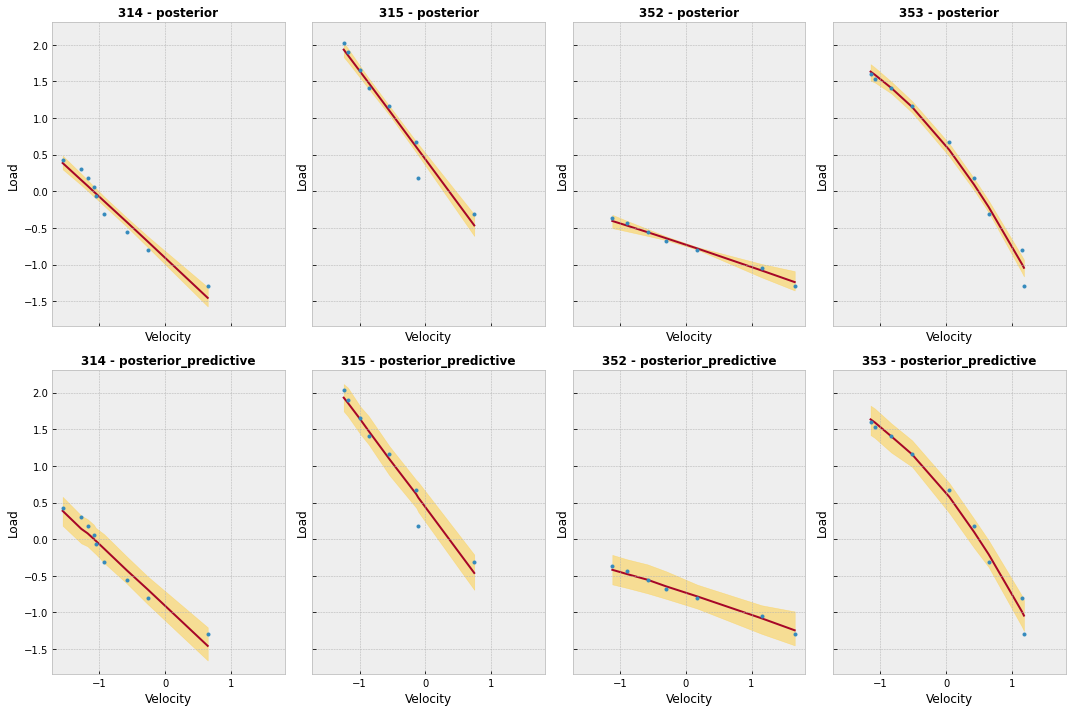

time: 2.3 s (started: 2022-09-29 07:26:39 +00:00)


In [ ]:
exercise_last_session_ids = regr_data.groupby(['exercise_id'])['session_id'].max().values
n_exercises = len(exercise_last_session_ids)

groups = ['posterior', 'posterior_predictive']
n_groups = len(groups)

fig, axes = plt.subplots(n_groups, n_exercises, figsize = (15, 10), sharex = True, sharey = True)

for i, cols in enumerate(axes):
    for j, cell in enumerate(cols):

        session_id = exercise_last_session_ids[j]

        filter = regr_data['session_id'] == session_id
        session_observation_ids = regr_data[filter].index.values

        plot_predictions(inference_data,
                         session_id,
                         session_observation_ids,
                         cell,
                         groups[i])
        
'''
fig.suptitle('Last Session Per Exercise',
             fontweight = 'bold',
             fontsize = 'x-large')
'''

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


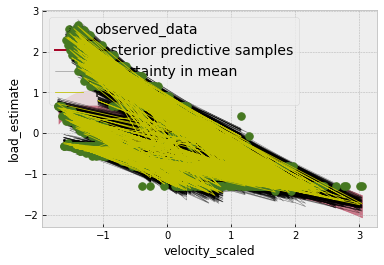

time: 4.32 s (started: 2022-09-29 07:27:18 +00:00)


In [ ]:
_ = az.plot_lm(idata = inference_data,
               y = 'load_estimate',
               x = 'velocity_scaled',
               y_model = 'load_mu',
               kind_pp = 'hdi')

## Prediction

### Generate Predictions

In [ ]:
def create_prediction_df(unique_session_df,
                         predict_velocity_series):
    unique_session_df = unique_session_df.copy()
    unique_session_df['_temp'] = True

    predict_velocity_df = pd.DataFrame(predict_velocity_series, columns = ['velocity_scaled'])
    predict_velocity_df['_temp'] = True

    df = (unique_session_df
          .merge(predict_velocity_df, on = ['_temp'])
          .drop('_temp', axis = 1))

    return df

time: 1.85 ms (started: 2022-09-22 21:17:16 +00:00)


In [ ]:
sessions = regr_data[['exercise', 'workout_start_time', 'exercise_id', 'session_id']].drop_duplicates()

velocity_start = 0.0
velocity_stop = np.ceil(regr_data['velocity'].max())
velocity = np.arange(velocity_start, velocity_stop*100 + 1)/100
velocity_scaled = velocity_scaler.transform(velocity.reshape(-1, 1)).flatten()

predict_velocities = pd.Series(velocity_scaled)

prediction_template = create_prediction_df(sessions, predict_velocities)
prediction_template

,exercise,workout_start_time,exercise_id,session_id,velocity_scaled
0,deadlift,2020-12-30 12:53:09,1,0,-1.933211
1,deadlift,2020-12-30 12:53:09,1,0,-1.901780
2,deadlift,2020-12-30 12:53:09,1,0,-1.870348
3,deadlift,2020-12-30 12:53:09,1,0,-1.838917
4,deadlift,2020-12-30 12:53:09,1,0,-1.807485
...,...,...,...,...,...
68737,squat,2022-09-22 20:16:19,3,341,4.227365
68738,squat,2022-09-22 20:16:19,3,341,4.258796
68739,squat,2022-09-22 20:16:19,3,341,4.290228
68740,squat,2022-09-22 20:16:19,3,341,4.321660


time: 51.6 ms (started: 2022-09-22 21:17:16 +00:00)


In [ ]:
prediction_template = prediction_template.merge(regr_data[['session_id', 'velocity_scaled', 'load_scaled']],
                                                how = 'left',
                                                on = ['session_id', 'velocity_scaled'])

prediction_template

,exercise,workout_start_time,exercise_id,session_id,velocity_scaled,load_scaled
0,deadlift,2020-12-30 12:53:09,1,0,-1.933211,NaN
1,deadlift,2020-12-30 12:53:09,1,0,-1.901780,NaN
2,deadlift,2020-12-30 12:53:09,1,0,-1.870348,NaN
3,deadlift,2020-12-30 12:53:09,1,0,-1.838917,NaN
4,deadlift,2020-12-30 12:53:09,1,0,-1.807485,NaN
...,...,...,...,...,...,...
68760,squat,2022-09-22 20:16:19,3,341,4.227365,NaN
68761,squat,2022-09-22 20:16:19,3,341,4.258796,NaN
68762,squat,2022-09-22 20:16:19,3,341,4.290228,NaN
68763,squat,2022-09-22 20:16:19,3,341,4.321660,NaN


time: 61.3 ms (started: 2022-09-22 21:17:16 +00:00)


In [ ]:
new_data = {'velocity_scaled': prediction_template['velocity_scaled'].values,
            'session_exercise_id': map_session_to_exercise_id,
            'session_id': prediction_template['session_id'].values}
            
new_coords = {'observation': prediction_template.index.values + len(regr_data)}

with quadratic_model:
    pm.set_data(new_data = new_data,
                coords = new_coords)
    
    predictions_idata = pm.sample_posterior_predictive(inference_data, predictions = True)

predictions_idata

Inference data with groups:
	> predictions
	> predictions_constant_data

time: 28.7 s (started: 2022-09-22 21:17:16 +00:00)


In [ ]:
predictions = inference_data.posterior_predictive['load_estimate']

time: 1.05 ms (started: 2022-09-22 21:21:48 +00:00)


In [ ]:
median = predictions.stack({'samples': ['chain', 'draw']}).median('samples')

time: 100 ms (started: 2022-09-22 21:21:51 +00:00)


In [ ]:
hdi = az.hdi(predictions, hdi_prob = 0.9)['load_estimate']
hdi_lower = hdi.sel({'hdi': 'lower'}, drop = True)
hdi_upper = hdi.sel({'hdi': 'higher'}, drop = True)

time: 503 ms (started: 2022-09-22 21:22:02 +00:00)


In [ ]:
prediction_df = regr_data.copy()

# Add predictions
prediction_df['load_scaled_median'] = median
prediction_df['load_scaled_lower'] = hdi_lower
prediction_df['load_scaled_upper'] = hdi_upper

# Inverse scale all values
prediction_df['velocity'] = velocity_scaler.inverse_transform(prediction_df['velocity_scaled'].values.reshape(-1, 1))
prediction_df['load'] = load_scaler.inverse_transform(prediction_df['load_scaled'].values.reshape(-1, 1))
prediction_df['load_median'] = load_scaler.inverse_transform(prediction_df['load_scaled_median'].values.reshape(-1, 1))
prediction_df['load_lower'] = load_scaler.inverse_transform(prediction_df['load_scaled_lower'].values.reshape(-1, 1))
prediction_df['load_upper'] = load_scaler.inverse_transform(prediction_df['load_scaled_upper'].values.reshape(-1, 1))

prediction_df

,exercise,workout_start_time,set,load,velocity,observation_weight,cycle_type,load_scaled,velocity_scaled,exercise_id,session_id,load_scaled_median,load_scaled_lower,load_scaled_upper,load_median,load_lower,load_upper
observation,,,,,,,,,,,,,,,,,
0,deadlift,2020-12-30 12:53:09,0,70.0,0.63,0.010152,n/a,-0.068759,0.046974,1,0,-0.110534,-2.284019,2.469263,68.299705,-20.161831,173.298310
1,deadlift,2020-12-30 12:53:09,1,80.0,0.50,0.015625,n/a,0.176940,-0.361636,1,0,0.139714,-2.217545,2.592804,78.484917,-17.456299,178.326483
2,deadlift,2020-12-30 12:53:09,2,90.0,0.49,0.019820,n/a,0.422638,-0.393067,1,0,0.168567,-2.151466,2.697107,79.659214,-14.766899,182.571641
3,deadlift,2020-12-30 12:53:09,3,100.0,0.64,0.019195,n/a,0.668336,0.078406,1,0,-0.151023,-2.490241,2.257592,66.651790,-28.555123,164.683237
4,deadlift,2020-12-30 12:53:09,4,110.0,0.48,0.031250,n/a,0.914035,-0.424499,1,0,0.174159,-2.330387,2.588012,79.886823,-22.049011,178.131437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,squat,2022-09-22 20:16:19,3,80.0,0.67,0.018346,YOLO,0.176940,0.172700,3,341,-0.298362,-2.743756,1.999798,60.655058,-38.873277,154.190919
2718,squat,2022-09-22 20:16:19,4,100.0,0.53,0.038673,YOLO,0.668336,-0.267341,3,341,-0.011304,-2.451828,2.434826,72.338400,-26.991695,171.896695
2719,squat,2022-09-22 20:16:19,5,120.0,0.39,0.096317,YOLO,1.159733,-0.707382,3,341,0.224860,-2.320772,2.894669,81.950365,-21.657704,190.612460


time: 39.5 ms (started: 2022-09-22 21:22:05 +00:00)


### Plot Last Sessions

In [ ]:
def plot_session(df, session_id, ax):
    filter = (df['session_id'] == session_id)# & (df['load_scaled_median'] >= 0)
    data = df[filter]

    auc = sklearn.metrics.auc(data['velocity_scaled'], data['load_scaled_median'])

    zero_velocity_load = data['load_scaled_median'].max()
    zero_velocity_load_lower = data['load_scaled_lower'].max()
    zero_velocity_load_upper = data['load_scaled_upper'].max()

    zero_load_velocity = data['velocity_scaled'].max()

    exercise = data['exercise'].values[0]
    workout_time = pd.to_datetime(data['workout_start_time'].values[0]).strftime('%Y-%m-%d')

    ax.plot('velocity_scaled',
            'load_scaled',
            marker = 'o',
            linestyle = '',
            label = 'Observed',
            zorder = 2,
            data = data)
    
    ax.plot('velocity_scaled',
            'load_scaled_median',
            label = 'Median',
            zorder = 1,
            data = data)

    ax.fill_between(x = 'velocity_scaled',
                    y1 = 'load_scaled_lower',
                    y2 = 'load_scaled_upper',
                    alpha = 0.5,
                    color = '#ffcd3c',
                    label = '90% HDI',
                    zorder = 0,
                    data = data)

    ax.set_title(f'{exercise.title()}\n{workout_time}',
                 fontsize = 'large',
                 fontweight = 'bold')
    
    ax.annotate(f'Zero Velocity Load: {zero_velocity_load:.0f} [{zero_velocity_load_lower:.0f}-{zero_velocity_load_upper:.0f}] kg\nZero Load Velocity: {zero_load_velocity:.2f} m/s\nArea Under Curve: {auc:.0f}',
                xy = [0.9855, 0.865],
                xycoords = 'axes fraction',
                horizontalalignment = 'right',
                verticalalignment = 'top',
                bbox = {'boxstyle': 'round',
                        'edgecolor': '#bcbcbc',
                        'facecolor': '#eeeeee'})
    
    ax.legend()
    
    ax.set_xlabel('Velocity')
    ax.set_ylabel('Load')

time: 3.34 ms (started: 2022-09-22 21:17:57 +00:00)


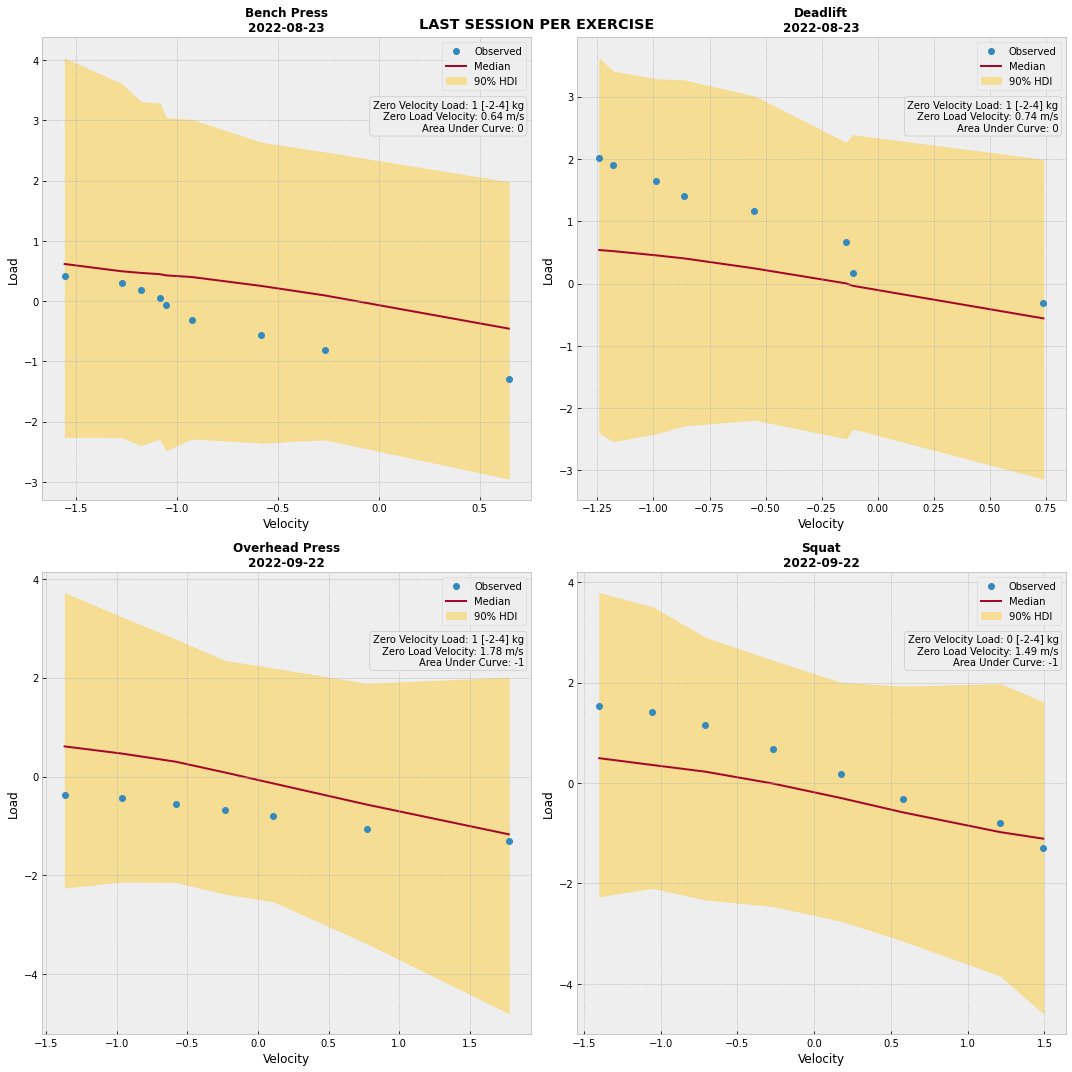

time: 955 ms (started: 2022-09-22 21:22:10 +00:00)


In [ ]:
exercise_last_session_ids = regr_data.groupby(['exercise_id'])['session_id'].max().values
n_exercises = len(exercise_last_session_ids)

n_cols = 1 if n_exercises == 1 else 2
n_rows = 1 if n_exercises <= 2 else  np.ceil(n_exercises/2).astype(int)

fig, axes = plt.subplots(n_cols, n_rows, figsize = (15, 15))

axes = np.array([axes])
axes = axes.flatten()

for i in np.arange(n_exercises):
    plot_session(prediction_df, exercise_last_session_ids[i], axes[i])

fig.suptitle('LAST SESSION PER EXERCISE',
             fontweight = 'bold',
             fontsize = 'x-large')

fig.tight_layout()

plt.show()

## Model Using Xarray

### Build Dataset For Inference

In [ ]:
regr_data_xr = (data[['load', 'set_velocities']]
                .pint.dequantify()
                .sel({'aggregation': 'max'}, drop = True)
                .where(data.coords['set_type'] != 'Back Off', drop = True)
                .where(data.coords['exercise'] != 'front squat', drop = True)
                .drop_vars(['set_type', 'training_cycle', 'cycle_type', 'max_load_pr_flag'])
                .rename({'set_velocities': 'velocity'})
)

regr_data_xr

<xarray.Dataset>
Dimensions:             (exercise: 4, workout_start_time: 194, set: 22)
Coordinates:
  * workout_start_time  (workout_start_time) datetime64[ns] 2020-12-30 ... 20...
  * exercise            (exercise) object 'bench press' 'deadlift' ... 'squat'
  * set                 (set) int64 0 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20 21
Data variables:
    load                (exercise, workout_start_time, set) float64 nan ... nan
    velocity            (exercise, workout_start_time, set) float64 nan ... nan

time: 344 ms (started: 2022-09-29 06:51:46 +00:00)


In [ ]:
# Standardize the variables for easier inference
xr_load = regr_data_xr['load'].values.flatten()
xr_velocity = regr_data_xr['velocity'].values.flatten()
xr_shape = regr_data_xr['load'].shape

xr_load_scaler = sklearn.preprocessing.StandardScaler()
xr_velocity_scaler = sklearn.preprocessing.StandardScaler()

xr_load_scaled = xr_load_scaler.fit_transform(xr_load.reshape(-1, 1)).reshape(xr_shape)
xr_velocity_scaled = xr_velocity_scaler.fit_transform(xr_velocity.reshape(-1, 1)).reshape(xr_shape)

dims = ['exercise', 'workout_start_time', 'set']
regr_data_xr['load_scaled'] = (dims, xr_load_scaled)
regr_data_xr['velocity_scaled'] = (dims, xr_velocity_scaled)

regr_data_xr

<xarray.Dataset>
Dimensions:             (exercise: 4, workout_start_time: 194, set: 22)
Coordinates:
  * workout_start_time  (workout_start_time) datetime64[ns] 2020-12-30 ... 20...
  * exercise            (exercise) object 'bench press' 'deadlift' ... 'squat'
  * set                 (set) int64 0 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20 21
Data variables:
    load                (exercise, workout_start_time, set) float64 nan ... nan
    velocity            (exercise, workout_start_time, set) float64 nan ... nan
    load_scaled         (exercise, workout_start_time, set) float64 nan ... nan
    velocity_scaled     (exercise, workout_start_time, set) float64 nan ... nan

time: 257 ms (started: 2022-09-29 06:51:47 +00:00)


In [ ]:
xr_stacked = regr_data_xr.stack(dimensions = {'exercise_workout': ['exercise', 'workout_start_time']})

time: 23.5 ms (started: 2022-09-29 06:53:03 +00:00)


In [ ]:
xr_stacked.to_dataframe().reset_index()

,set,exercise,workout_start_time,load,velocity,load_scaled,velocity_scaled
0,0,bench press,2020-12-30 00:00:00,NaN,NaN,NaN,NaN
1,0,bench press,2020-12-30 12:53:09,NaN,NaN,NaN,NaN
2,0,bench press,2021-01-03 12:40:44,NaN,NaN,NaN,NaN
3,0,bench press,2021-01-05 00:00:00,NaN,NaN,NaN,NaN
4,0,bench press,2021-01-05 10:56:06,20.0,0.77,-1.294422,0.490185
...,...,...,...,...,...,...,...
17067,21,squat,2022-09-24 20:14:33,NaN,NaN,NaN,NaN
17068,21,squat,2022-09-25 19:53:38,NaN,NaN,NaN,NaN
17069,21,squat,2022-09-26 20:45:04,NaN,NaN,NaN,NaN
17070,21,squat,2022-09-27 19:52:39,NaN,NaN,NaN,NaN


time: 34.7 ms (started: 2022-09-29 06:53:48 +00:00)


### Build PyMC Model For Dataset

#### Functions

In [ ]:
def generate_idx(shape):
    idx0 = np.zeros(shape).astype(int)
    idx1 = np.zeros(shape).astype(int)
    idx2 = np.zeros(shape[0:2]).astype(int)
    
    for i in np.arange(shape[0]):
        idx0[i, :, :] = i
        idx2[i, :] = i

    for i in np.arange(shape[1]):
        idx1[:, i, :] = i
    
    return [idx0, idx1, idx2]

time: 2.42 ms (started: 2022-09-28 06:51:01 +00:00)


In [ ]:
def build_xr_model(x_name, y_name, data):
    x = data[x_name].values
    y = data[y_name].values

    idx0, idx1, idx2 = generate_idx(x.shape)

    dims = data[x_name].dims    
    coords = {key: data[key].values for key in dims}

    with pm.Model(coords = coords) as model:
    
        # Inputs
        x = pm.Normal(name = 'velocity',
                      mu = 0.0,
                      sigma = 1.0,
                      observed = x,
                      dims = dims)

        # Layer 0 Parameters
        intercept_layer0 = pm.Normal(name = 'intercept_layer0',
                                     mu = 0.0,
                                     sigma = 1.0)
        
        intercept_layer0_sigma = pm.HalfNormal(name = 'intercept_layer0_sigma',
                                               sigma = 1.0)

        trend_layer0 = pm.HalfNormal(name = 'trend_layer0',
                                     sigma = 1.0)
        
        curve_layer0 = pm.HalfNormal(name = 'curve_layer0',
                                     sigma = 3.0)

        # Layer 1 Parameters
        intercept_layer1_offset = pm.Normal(name = 'intercept_layer1_offset',
                                            mu = 0.0,
                                            sigma = 1.0,
                                            dims = dims[0])
        
        intercept_layer1 = pm.Deterministic(name = 'intercept_layer1',
                                            var = (intercept_layer0
                                                   + intercept_layer0_sigma
                                                   * intercept_layer1_offset),
                                            dims = dims[0])
        
        intercept_layer1_sigma = pm.HalfNormal(name = 'intercept_layer1_sigma',
                                               sigma = 1.0,
                                               dims = dims[0])

        trend_layer1 = pm.HalfNormal(name = 'trend_layer1',
                                     sigma = trend_layer0,
                                     dims = dims[0])
        
        curve_layer1 = pm.HalfNormal(name = 'curve_layer1',
                                     sigma = curve_layer0,
                                     dims = dims[0])
    
        # Layer 2 Parameters
        intercept_layer2_offset = pm.Normal(name = 'intercept_layer2_offset',
                                            mu = 0.0,
                                            sigma = 1.0,
                                            dims = dims[0:2])
        
        intercept_layer2 = pm.Deterministic(name = 'intercept_layer2',
                                            var = (intercept_layer1[idx2]
                                                   + intercept_layer1_sigma[idx2]
                                                   * intercept_layer2_offset),
                                            dims = dims[0:2])
        
        trend_layer2 = pm.HalfNormal(name = 'trend_layer2',
                                     sigma = trend_layer1[idx2],
                                     dims = dims[0:2])
        
        curve_layer2 = pm.HalfNormal(name = 'curve_layer2',
                                     sigma = curve_layer1[idx2],
                                     dims = dims[0:2])

        # Final Parameters
        intercept = intercept_layer2[idx1, idx0]
        trend = trend_layer2[idx1, idx0]
        curve = curve_layer2[idx1, idx0]

        error = pm.HalfNormal(name = f'{y_name}_error',
                              sigma = 1.0)
        
        # Expected value
        mu = pm.Deterministic(name = f'{y_name}_mu',
                              var = (intercept
                                     - trend*x
                                     - curve*x**2),
                              dims = dims)

        # Likelihood of observed values
        likelihood = pm.Normal(name = y_name,
                               mu = mu,
                               sigma = error,
                               observed = y,
                               dims = dims)
    
    display(pm.model_to_graphviz(model))

    return model

time: 8.97 ms (started: 2022-09-28 07:02:45 +00:00)


#### Inference

/usr/local/lib/python3.7/dist-packages/pymc/model.py:1431: ImputationWarning: Data in load_scaled contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


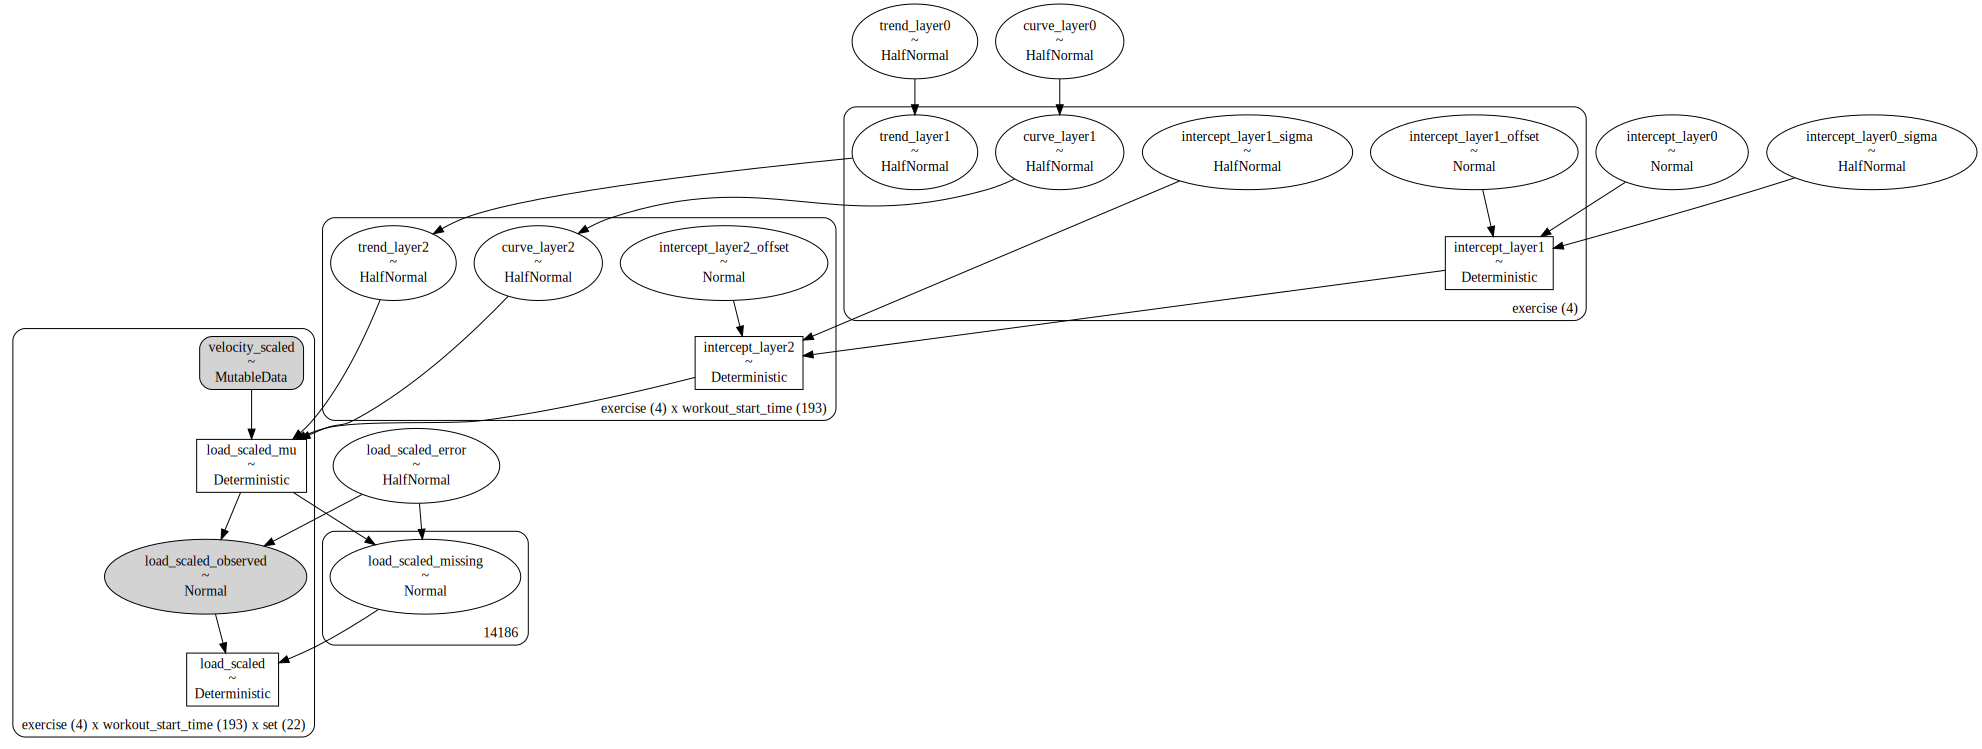

time: 1.69 s (started: 2022-09-28 07:34:49 +00:00)


In [ ]:
xr_model = build_xr_model(x_name = 'velocity_scaled',
                          y_name = 'load_scaled',
                          data = regr_data_xr)

In [ ]:
xr_inference_data = sample(model = xr_model,
                           prior_pred = False,
                           post_pred = False,
                           draws = 1000,
                           tune = 1000,
                           chains = n_devices,
                           target_accept = 0.98)

Compiling...


IndexError: ignored

time: 10.2 s (started: 2022-09-28 07:08:48 +00:00)


In [ ]:
xr_inference_data

## 3D Hierarchical Model

In [ ]:
import pymc as pm
import numpy as np
import xarray as xr
import pandas as pd
import arviz as az

In [ ]:
# Create xarray with test data
coords = {'exercise': ['squat', 'overhead press', 'deadlift'],
          'date': ['2020-02-24', '2020-02-26', '2020-03-21', '2020-03-25', '2020-04-06', '2020-07-25', '2020-08-10'],
          'observation': [1, 2, 3, 4, 5, 6]}

dims = list(coords.keys())

velocities = np.array([[[1.198, 1.042, 0.875, 0.735, 0.574, 0.552],
                        [1.261, 0.993, 0.857, 0.828, 0.624, 0.599],
                        [1.224, 1.028, 0.990, 0.742, 0.595, 0.427],
                        [1.112, 0.999, 0.865, 0.751, 0.607, 0.404],
                        [1.157, 1.010, 0.849, 0.716, 0.593, 0.536],
                        [1.179, 1.060, 0.898, 0.783, 0.615, 0.501],
                        [1.209, 1.192, 0.979, 1.025, 0.875, 0.887]],
                       
                       [[0.911, 0.933, 0.779, 0.629, 0.528, 0.409],
                        [1.004, 0.863, 0.770, 0.611, 0.511, 0.376],
                        [0.980, 0.828, 0.766, 0.611, 0.529, 0.349],
                        [1.024, 0.933, 0.841, 0.734, 0.551, 0.287],
                        [0.985, 0.852, 0.599, 0.522, 0.313, 0.234],
                        [0.996, 0.763, 0.758, 0.542, 0.463, 0.378],
                        [1.066, 0.915, 0.786, 0.686, 0.565, 0.429]],
              
                       [[0.654, 1.004, 0.727, 0.483, 0.344, 0.317],
                        [0.885, 0.738, 0.577, 0.495, 0.335, 0.291],
                        [0.749, 0.695, 0.539, 0.461, 0.395, 0.279],
                        [0.801, 0.548, 0.404, 0.424, 0.337, 0.338],
                        [0.770, 0.642, 0.602, 0.493, 0.394, 0.290],
                        [0.766, 0.545, 0.426, 0.431, 0.349, 0.329],
                        [0.787, 0.640, 0.480, 0.401, 0.395, 0.304]]])

loads = np.array([[[20.0,  40.0,  60.0,  80.0, 100.0, 110.0],
                   [20.0,  40.0,  60.0,  80.0, 100.0, 110.0],
                   [20.0,  40.0,  60.0,  80.0, 100.0, 117.5],
                   [20.0,  40.0,  60.0,  80.0, 100.0, 115.0],
                   [20.0,  40.0,  60.0,  80.0, 100.0, 110.0],
                   [20.0,  40.0,  60.0,  80.0, 100.0, 110.0],
                   [20.0,  30.0,  40.0,  50.0,  60.0,  70.0]],
         
                  [[20.0,  25.0,  30.0,  35.0,  40.0,  45.0],
                   [20.0,  25.0,  30.0,  35.0,  40.0,  45.0],
                   [20.0,  25.0,  30.0,  35.0,  40.0,  45.0],
                   [20.0,  25.0,  30.0,  35.0,  40.0,  45.0],
                   [20.0,  30.0,  40.0,  45.0,  50.0,  52.5],
                   [20.0,  30.0,  35.0,  40.0,  42.5,  45.0],
                   [20.0,  25.0,  30.0,  35.0,  40.0,  45.0]],
         
                  [[60.0,  80.0, 100.0, 120.0, 140.0, 145.0],
                   [60.0,  80.0, 100.0, 120.0, 140.0, 145.0],
                   [60.0,  80.0, 100.0, 120.0, 127.5, 140.0],
                   [60.0, 100.0, 120.0, 125.0, 140.0, 145.0],
                   [60.0,  80.0, 100.0, 120.0, 130.0, 140.0],
                   [60.0, 100.0, 120.0, 125.0, 130.0, 132.5],
                   [70.0,  90.0, 120.0, 135.0, 140.0, 150.0]]])

mask = np.random.binomial(n = 1, p = 0.8, size = velocities.shape)

dataset = (xr.Dataset({'velocity': (dims, velocities),
                       'load': (dims, loads),
                       'mask': (dims, mask)},
                      coords = coords)
             .set_coords(['mask']))

dataset['velocity_std'] = (dataset['velocity'] - dataset['velocity'].mean())/dataset['velocity'].std()
dataset['load_std'] = (dataset['load'] - dataset['load'].mean())/dataset['load'].std()

dataset['velocity_std_masked'] = dataset['velocity_std'].where(dataset['mask'])
dataset['load_std_masked'] = dataset['load_std'].where(dataset['mask'])

dataset

<xarray.Dataset>
Dimensions:              (exercise: 3, date: 7, observation: 6)
Coordinates:
    mask                 (exercise, date, observation) int64 1 0 1 1 ... 1 0 1 1
  * exercise             (exercise) <U14 'squat' 'overhead press' 'deadlift'
  * date                 (date) <U10 '2020-02-24' '2020-02-26' ... '2020-08-10'
  * observation          (observation) int64 1 2 3 4 5 6
Data variables:
    velocity             (exercise, date, observation) float64 1.198 ... 0.304
    load                 (exercise, date, observation) float64 20.0 ... 150.0
    velocity_std         (exercise, date, observation) float64 1.988 ... -1.483
    load_std             (exercise, date, observation) float64 -1.237 ... 2.001
    velocity_std_masked  (exercise, date, observation) float64 1.988 ... -1.483
    load_std_masked      (exercise, date, observation) float64 -1.237 ... 2.001

In [ ]:
n_exercises = dataset.dims['exercise']
n_dates = dataset.dims['date']
n_observations = dataset.dims['observation']

exercise_date_idx = [[i]*n_dates for i in np.arange(n_exercises)]
exercise_idx = [[[i]*n_observations for j in np.arange(n_dates)] for i in np.arange(n_exercises)]
date_idx = [[[j]*n_observations for j in np.arange(n_dates)] for i in np.arange(n_exercises)]

velocity_data = dataset['velocity_std'].to_masked_array()
load_data = dataset['load_std'].to_masked_array()

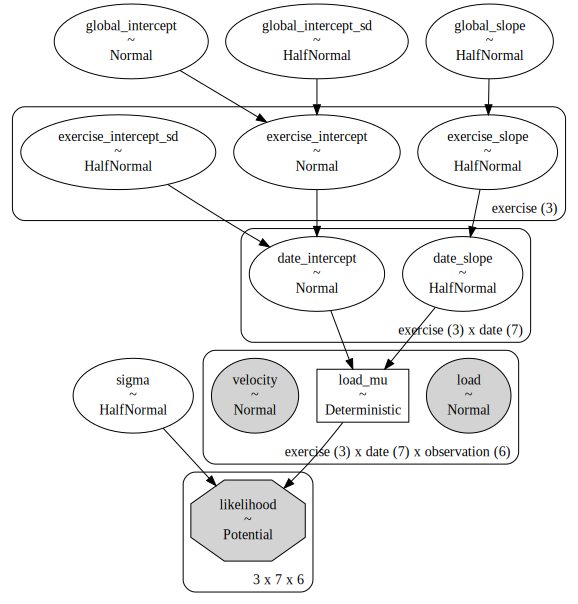

In [ ]:
# Create PyMC
with pm.Model(coords = coords) as model:

    # Impute missing values
    velocity = pm.Normal(name = 'velocity',
                         mu = 0.0,
                         sigma = 1.0,
                         observed = velocity_data,
                         dims = dims)
    
    load = pm.Normal('load',
                     mu = 0.0,
                     sigma = 1.0,
                     observed = load_data,
                     dims = dims)
    
    # Global parameters
    global_intercept = pm.Normal('global_intercept', mu = 0, sigma = 1)
    global_intercept_sd = pm.HalfNormal('global_intercept_sd', sigma = 1)

    global_slope = pm.HalfNormal('global_slope', sigma = 1)

    # Exercise parameters
    exercise_intercept = pm.Normal('exercise_intercept', mu = global_intercept, sigma = global_intercept_sd, dims = 'exercise')
    exercise_intercept_sd = pm.HalfNormal('exercise_intercept_sd', sigma = 1, dims = 'exercise')

    exercise_slope = pm.HalfNormal('exercise_slope', sigma = global_slope, dims = 'exercise')
    
    # Date parameters
    date_intercept = pm.Normal('date_intercept', mu = exercise_intercept[exercise_date_idx], sigma = exercise_intercept_sd[exercise_date_idx], dims = ['exercise', 'date'])
    date_slope = pm.HalfNormal('date_slope', sigma = exercise_slope[exercise_date_idx], dims = ['exercise', 'date'])

    # Model error
    sigma = pm.HalfNormal('sigma', sigma = 1)

    # Expected value
    mu = pm.Deterministic(name = 'load_mu',
                          var = date_intercept[exercise_idx, date_idx] + date_slope[exercise_idx, date_idx]*velocity_data,
                          dims = dims)

    # Likelihood of observed values

    '''
    load_estimate = pm.Normal(name = 'load_estimate',
                              mu = mu,
                              sigma = sigma,
                              observed = load_data,
                              dims = dims)
    '''

    load_estimate = pm.Potential('load_estimate', pm.logp(pm.Normal.dist(mu = mu, sigma = sigma), load_data)*load_data.mask)

pm.model_to_graphviz(model)

In [ ]:
model.point_logps()

{'global_intercept': -0.92,
 'global_intercept_sd': -0.73,
 'global_slope': -0.73,
 'exercise_intercept': -2.76,
 'exercise_intercept_sd': -2.18,
 'exercise_slope': -2.18,
 'date_intercept': -19.3,
 'date_slope': -15.24,
 'sigma': -0.73,
 'velocity': -178.79,
 'load': -178.79,
 'likelihood': 0.0}

In [ ]:
three_dim_idata = pm.sample_prior_predictive(model = model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  """Entry point for launching an IPython kernel.


In [ ]:
three_dim_idata.extend(pm.sample(model = model, draws = 500, tune = 500, chains = 1))

ERROR:pymc:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
three_dim_idata.extend(pm.sample_posterior_predictive(model = model, trace = three_dim_idata))

/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


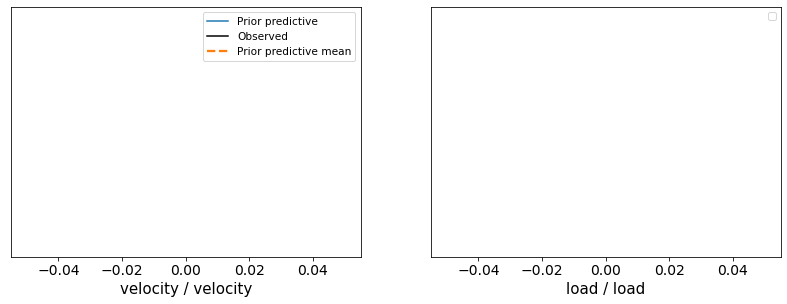

In [ ]:
_ = az.plot_ppc(three_dim_idata,
                group = 'prior',
                coords = {'exercise': ['Squat'],
                          'date': ['2020-08-10']})